In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import reciprocal
from reciprocal.kspace import KSpace
from reciprocal.canvas import Canvas, choose_color
from reciprocal.lattice import LatticeVectors, Lattice
from reciprocal.kvector import KVectorGroup
from reciprocal.symmetry import Symmetry
from reciprocal.utils import apply_symmetry_operators
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Circle
import matplotlib.cm as cm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['image.cmap']='plasma'



In [45]:
def get_lattice_vectors(shape):
    if shape == 'square':
        return LatticeVectors.from_lengths_angle(np.pi*2, np.pi*2, 90.)
    elif shape == 'rectangle':
        return LatticeVectors.from_lengths_angle(np.pi*2*1.5, np.pi*2, 90.)
    elif shape == 'hexagon':
        return LatticeVectors.from_lengths_angle(np.pi*2, np.pi*2, 60.)
    elif shape == 'oblique':
        return LatticeVectors.from_lengths_angle(np.pi*2, np.pi*2, 75.)
    
def get_symmetry(shape):
    if shape == 'square':
        return 'D4'
    elif shape == 'rectangle':
        return 'D2'
    elif shape == 'hexagon':
        return 'D6'
    elif shape == 'oblique':
        return 'C2'

# Real Space Lattices

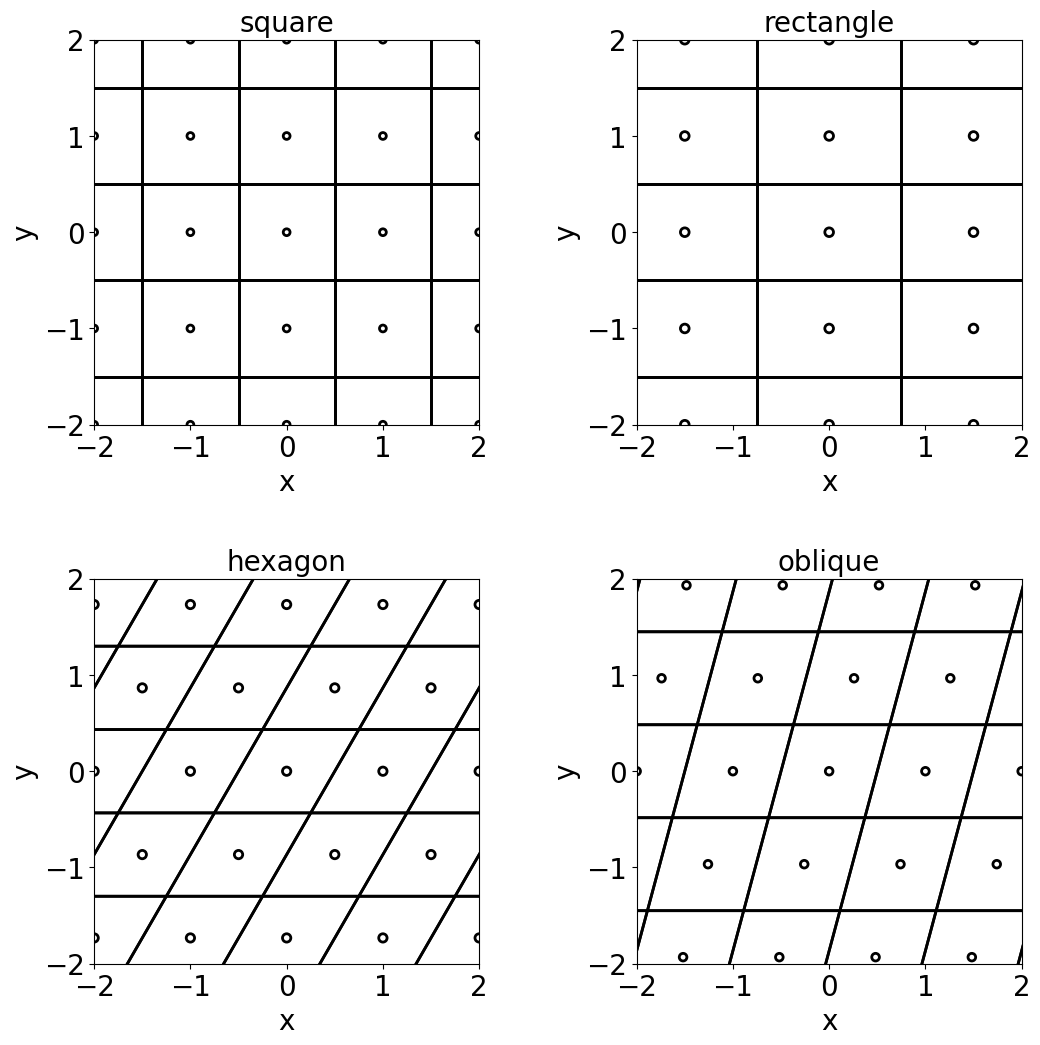

In [4]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    canvas.plot_tesselation(lat)
    canvas.plot_lattice(lat)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.title(lat_shape, fontsize=20)    

AttributeError: 'UnitCell' object has no attribute 'weight_points'

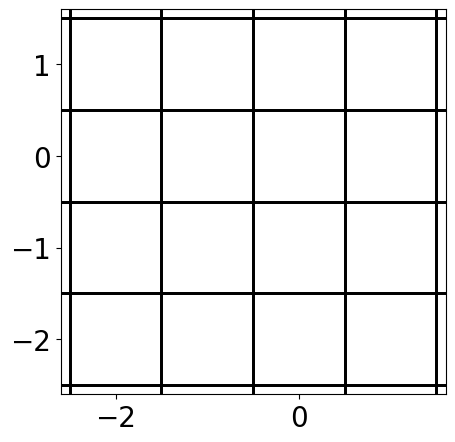

In [5]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    canvas.plot_tesselation(lat)
    #canvas.plot_lattice(lat)
    sampling, weighting = lat.unit_cell.sample(use_symmetry=False)
    canvas.plot_point_sampling(sampling)
    print(np.unique(weighting))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.title(lat_shape, fontsize=20)

# Reciprocal Lattices
## Irreducible Brillouin Zone & High Symmetry Points

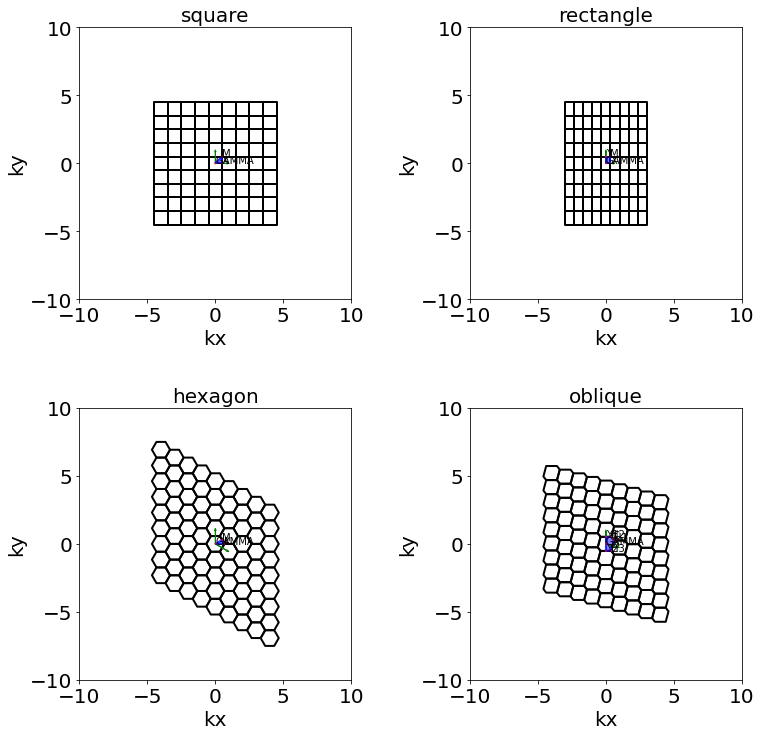

In [4]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)    
    canvas.plot_vectors(rlat)    
    canvas.plot_irreducible_uc(rlat.unit_cell)
    canvas.plot_special_points(rlat.unit_cell)
    

    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(lat_shape, fontsize=20)

## Weighted Sampling of the BZ

unique weighting: [0.25 0.5  1.  ]
integration value check: 1.0
unique weighting: [0.25 0.5  1.  ]
integration value check: 1.0
unique weighting: [0.5 1. ]
integration value check: 1.0
unique weighting: [0.5 1. ]
integration value check: 1.0


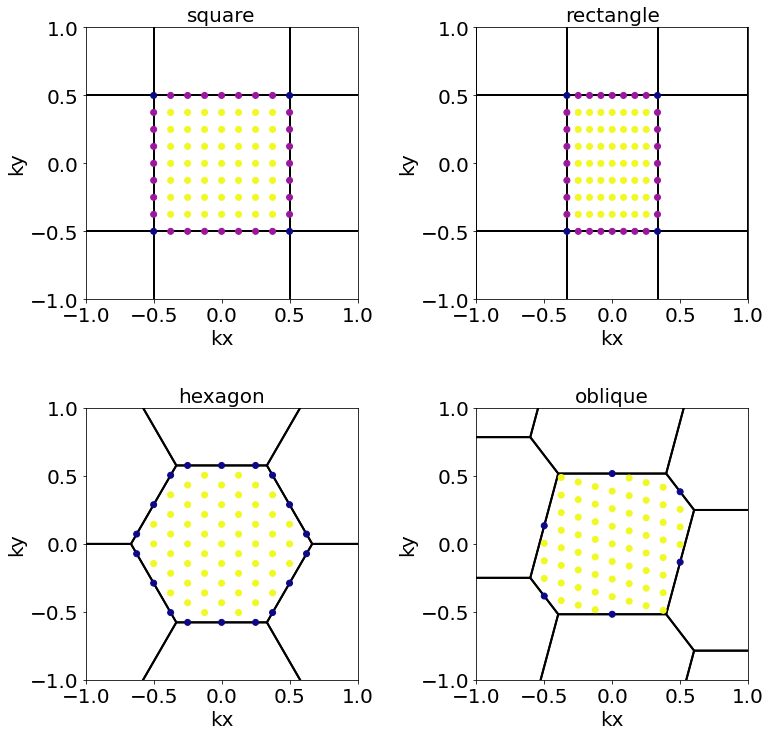

In [6]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    #print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    #print("lattice lengths: [{} {}]".format(rlat.vectors.length1, rlat.vectors.length2))
    canvas.plot_tesselation(rlat)    
    constraint = {'type':'n_points', 'value':5}
    sampling, weighting, int_element = rlat.unit_cell.sample(use_symmetry=False,
                                                            constraint=constraint)
    #print(sampling)
    #print("integration element: {}".format(int_element))
    print("unique weighting: {}".format(np.unique(weighting)))
    #print(np.sum(weighting))
    #print(weighting)
    canvas.plot_point_sampling_weighted(sampling, weighting)
    full_area = rlat.unit_cell.area()
    weight_sum = np.sum(int_element*weighting)
    print("integration value check: {}".format(weight_sum))
    #print("simple check: {}".format(full_area/int_element))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

## Weighted Sampling of the IBZ

square
integration element: 0.015625
unique weighting: [0.125 0.25  0.5   1.   ]
integration value check: 1.0
rectangle
integration element: 0.015625
unique weighting: [0.25 0.5  1.  ]
integration value check: 1.0
hexagon
integration element: 0.015625
unique weighting: [0.08333333 0.25       0.5        1.        ]
integration value check: 1.0
oblique
integration element: 0.015625
unique weighting: [0.5 1. ]
integration value check: 1.0


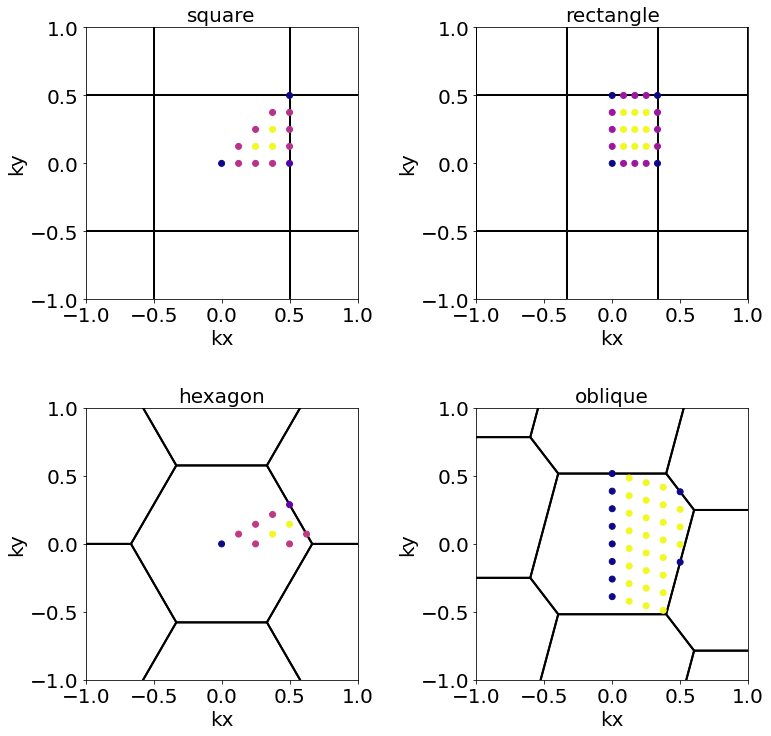

In [47]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)    
    sampling, weighting, int_element, sym_ops = rlat.unit_cell.sample_irreducible()
    
    print("integration element: {}".format(int_element))
    print("unique weighting: {}".format(np.unique(weighting)))
    canvas.plot_point_sampling_weighted(sampling, weighting)
    full_area = rlat.unit_cell.area()
    weight_sum = np.sum(int_element*weighting)
    symmetry_multiplier = rlat.unit_cell.symmetry().get_n_symmetry_ops()
    print("integration value check: {}".format(symmetry_multiplier*weight_sum))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

## BZ Sampling from symmetry

square
integration value check: 1.0
rectangle
integration value check: 1.0
hexagon
integration value check: 1.0000000000000002
oblique
integration value check: 1.0


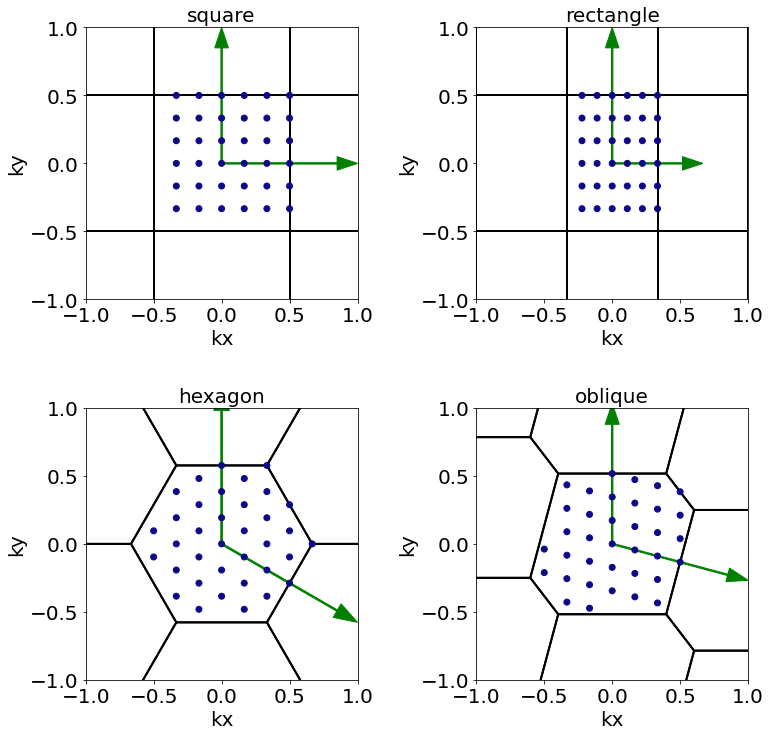

In [48]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    #print("lattice lengths: [{} {}]".format(rlat.vectors.length1, rlat.vectors.length2))
    canvas.plot_tesselation(rlat)    
    canvas.plot_vectors(rlat)  
    constraint = {'type':'n_points', 'value':4}
    sampling, weighting, int_element = rlat.unit_cell.sample(use_symmetry=True,
                                                            constraint=constraint)
    #print(sampling)
    #print("integration element: {}".format(int_element))
    #print("unique weighting: {}".format(np.unique(weighting)))
    #print(np.sum(weighting))
    canvas.plot_point_sampling_weighted(sampling, weighting)
    #full_area = rlat.unit_cell.area()
    weight_sum = np.sum(weighting)
    print("integration value check: {}".format(weight_sum))
    #print("simple check: {}".format(full_area/int_element))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

# Kspace
## 

square
n_max: 3
rectangle
n_max: 4
hexagon
n_max: 3
oblique
n_max: 3


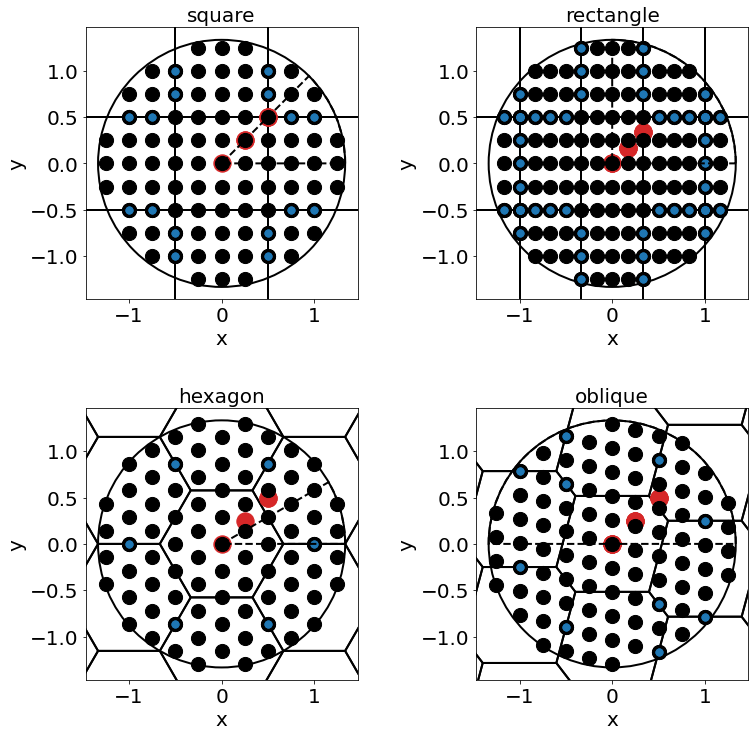

In [113]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])
    canvas = Canvas(ax=ax)
    wvl = 1.5*np.pi
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    #families = kspace.periodic_sampler.sample_bloch_families(restrict_to_sym_cone=True)
    constraint = {'type':'n_points', 'value':3}
    sampling, weighting, int_element, sym_ops = rlat.unit_cell.sample_irreducible(constraint=constraint)
    plt.scatter(sampling[:, 0], sampling[:,0], s=300, c='tab:red')
    #print(sampling.shape)
    #print(len(sym_ops))
    #print(len(sym_ops[0]))
    #canvas.plot_point_sampling(sampling)
    families, all_kv, sym_ops = kspace.periodic_sampler._bloch_fam_from_sample(sampling, 1e-5, False, symmetries=sym_ops)
    #canvas.plot_bloch_families(families)
    all_points = []
    for num, fam in families.items():
        #if not num == 1:
        #    continue
        #canvas.plot_point_sampling(fam, color=color)        
        #plt.scatter(fam.kx, fam.ky, s=200, c='k')
        #print(fam.kx, fam.ky, fam.order1, fam.order2, sym_ops[num])
        #for row in range(fam.n_rows):
        #print(sym_ops[num])
        #print(sym_ops[num])
        sym = rlat.unit_cell.symmetry()-sym_ops[num]
        
        
        sym_points = sym.apply_symmetry_operators(fam.k)
        #print(fam.n_rows, sym_points.shape[0])
        #print(sym_points)
        all_points.append(sym_points)
        #plt.scatter(sym_points[:,0], sym_points[:,1], s=50, c='tab:blue')
        #print(sym)
        #print(sym_points)
        #print(sym_points.shape[0])        
        #color = choose_color(num, len(families))
        #canvas.plot_point_sampling(sym_points, color=color)
        
    all_points = np.vstack(all_points)
    plt.scatter(all_points[:,0], all_points[:, 1], s=200, c='k')
    if True:
        duplicates = []
        is_duplicate = np.zeros(all_points.shape[0], dtype=bool)
        for row in range(all_points.shape[0]):
            point0 = all_points[row, :]
            if is_duplicate[row]:
                pass #continue
            for row2 in range(all_points.shape[0]):
                if row == row2:
                    continue
                if is_duplicate[row2]:
                    pass #continue
                point1 = all_points[row2, :]
                if np.linalg.norm(point0-point1) < 1e-6:
                    duplicates.append(point0)
                    is_duplicate[row] = True
                    is_duplicate[row2] = True
        if len(duplicates) > 0:
            duplicates = np.vstack(duplicates)
            plt.scatter(duplicates[:, 0], duplicates[:, 1], s=50, c='tab:blue')
    canvas.plot_symmetry_cone(kspace)
    
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-k0*1.1, k0*1.1])
    plt.ylim([-1.1*k0, 1.1*k0])
    plt.title(lat_shape, fontsize=20)

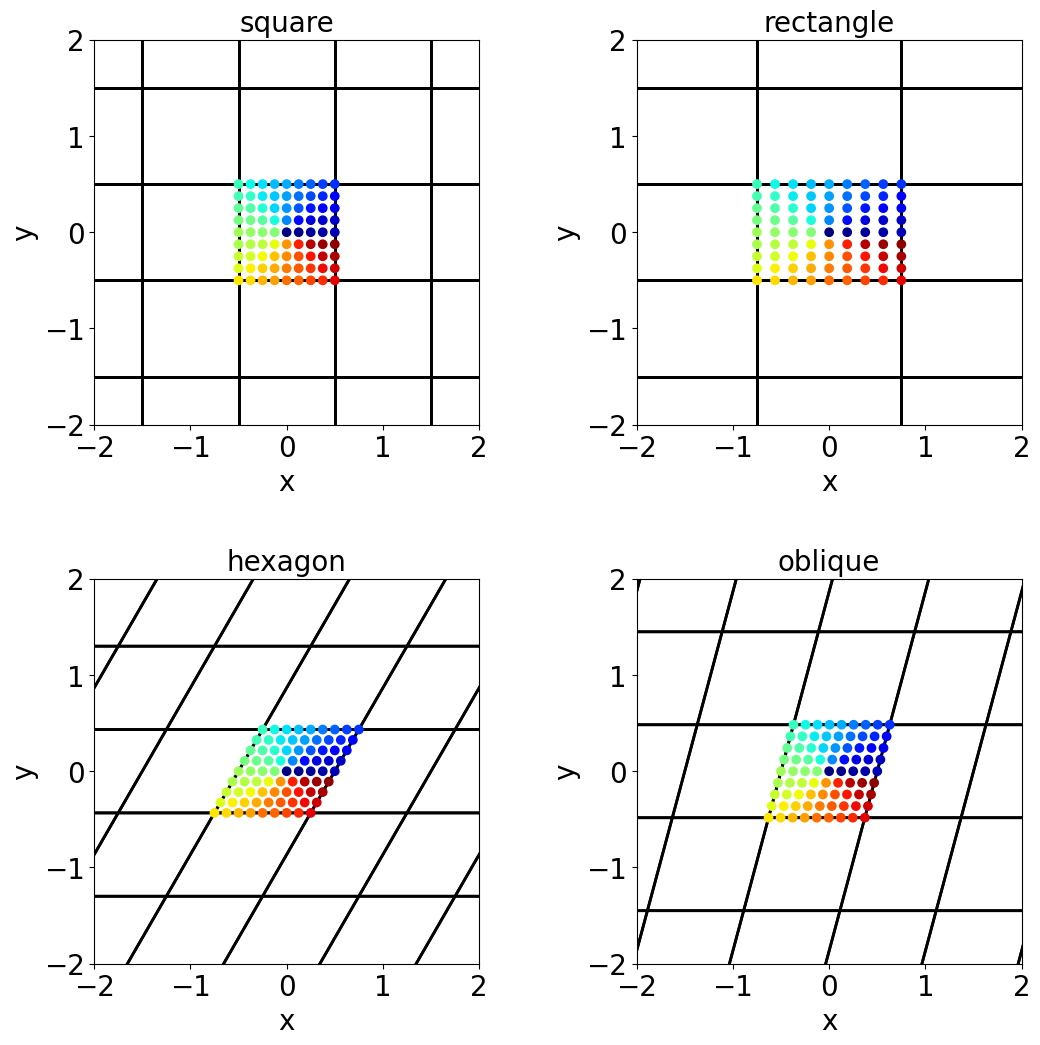

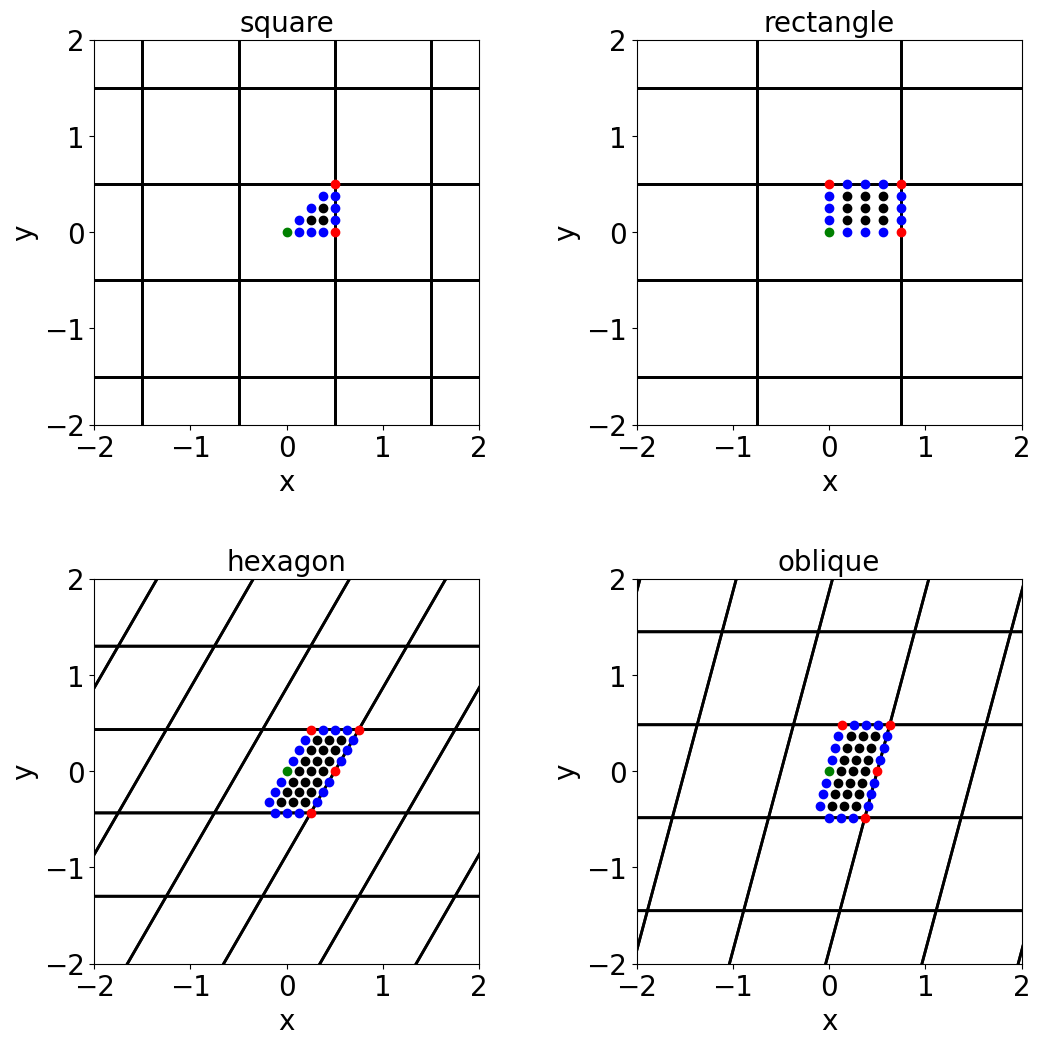

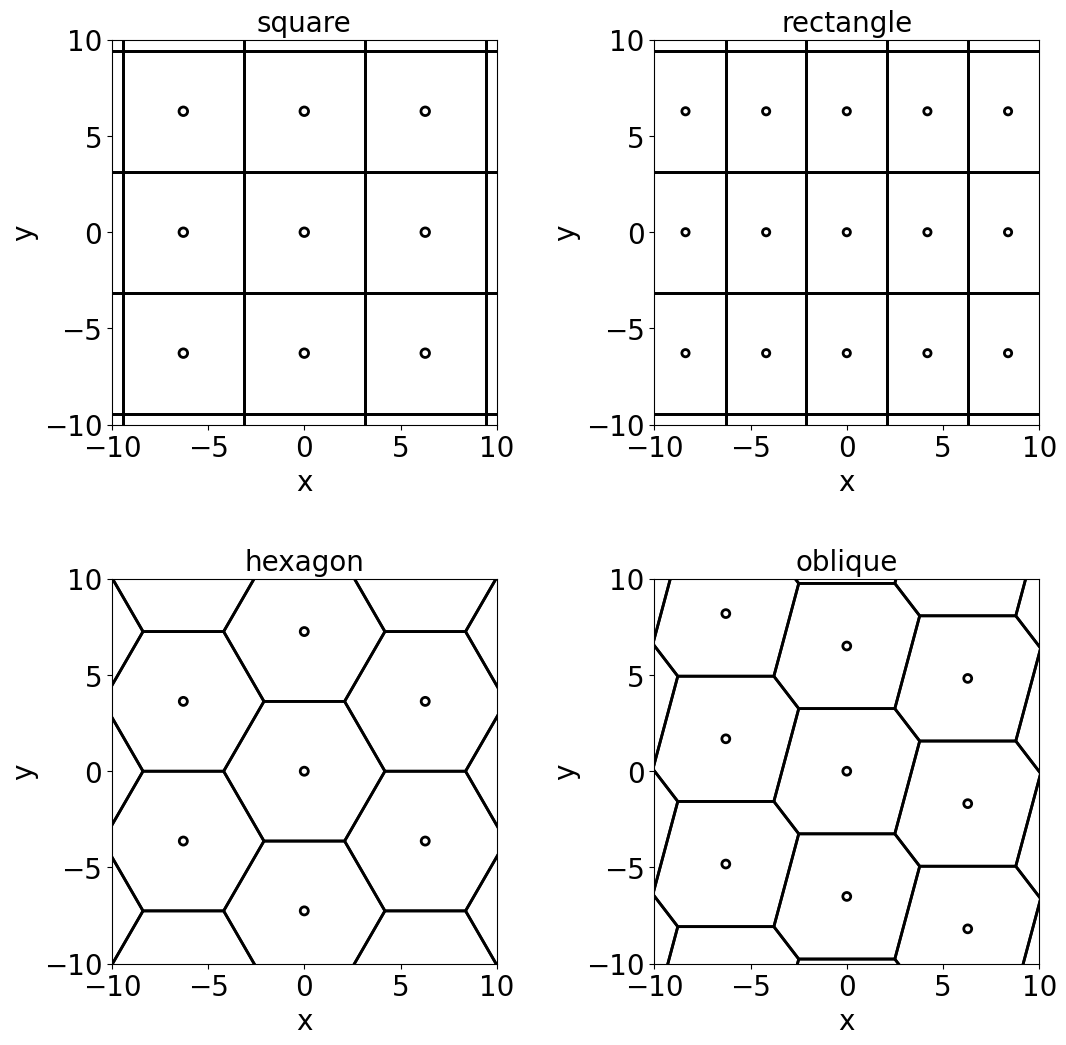

In [8]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)
    canvas.plot_lattice(rlat)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(lat_shape, fontsize=20)

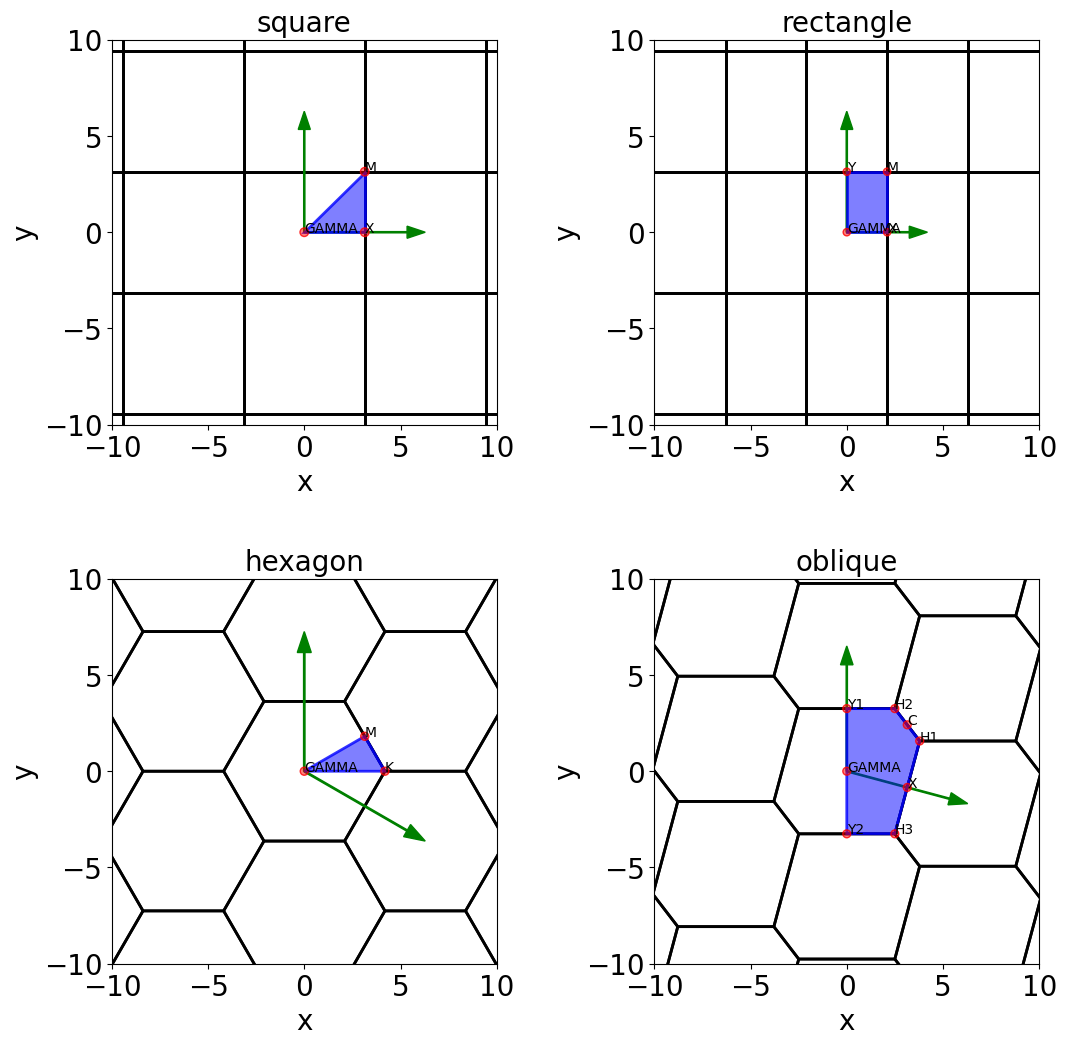

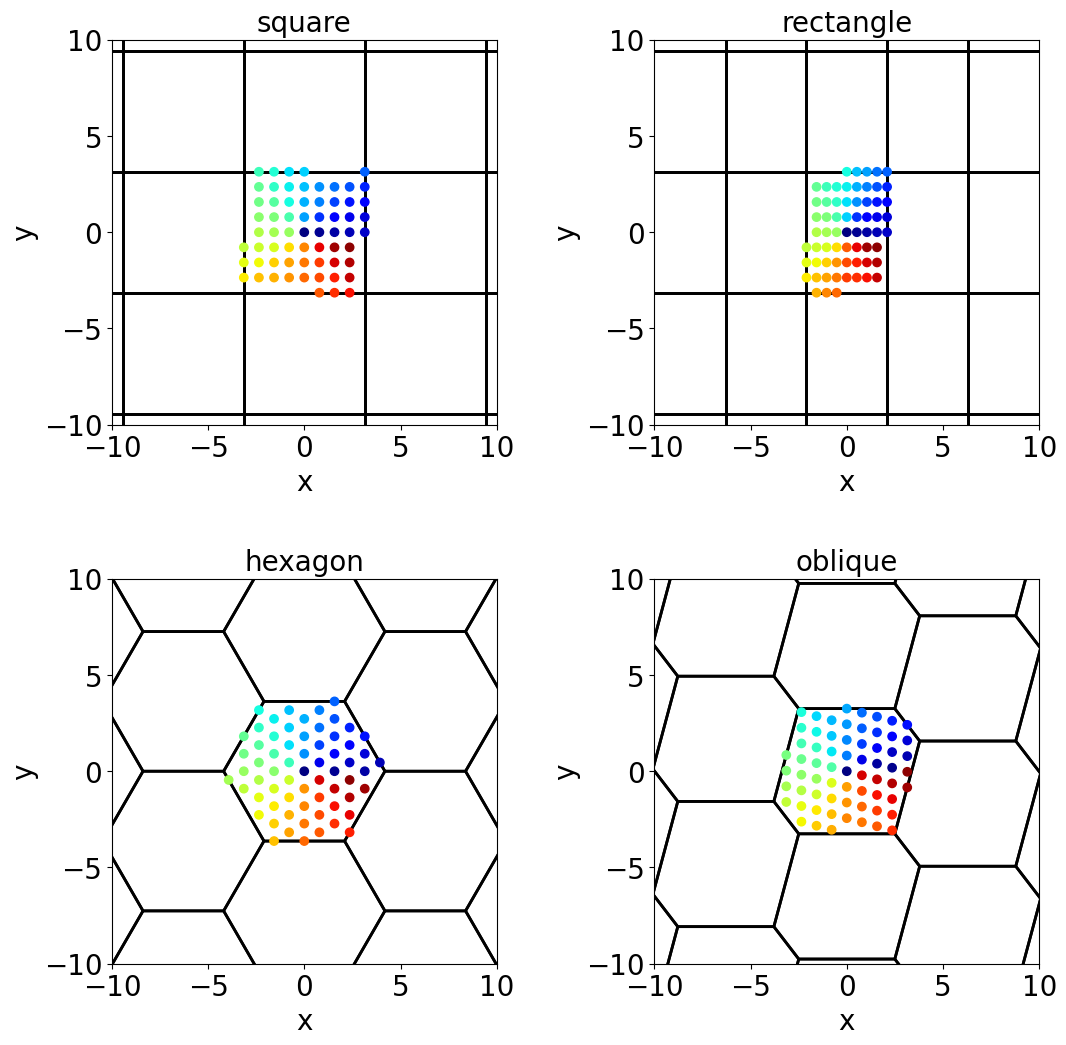

In [10]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)        
    sample = rlat.unit_cell.sample()
    canvas.plot_sampling(sample)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(lat_shape, fontsize=20)

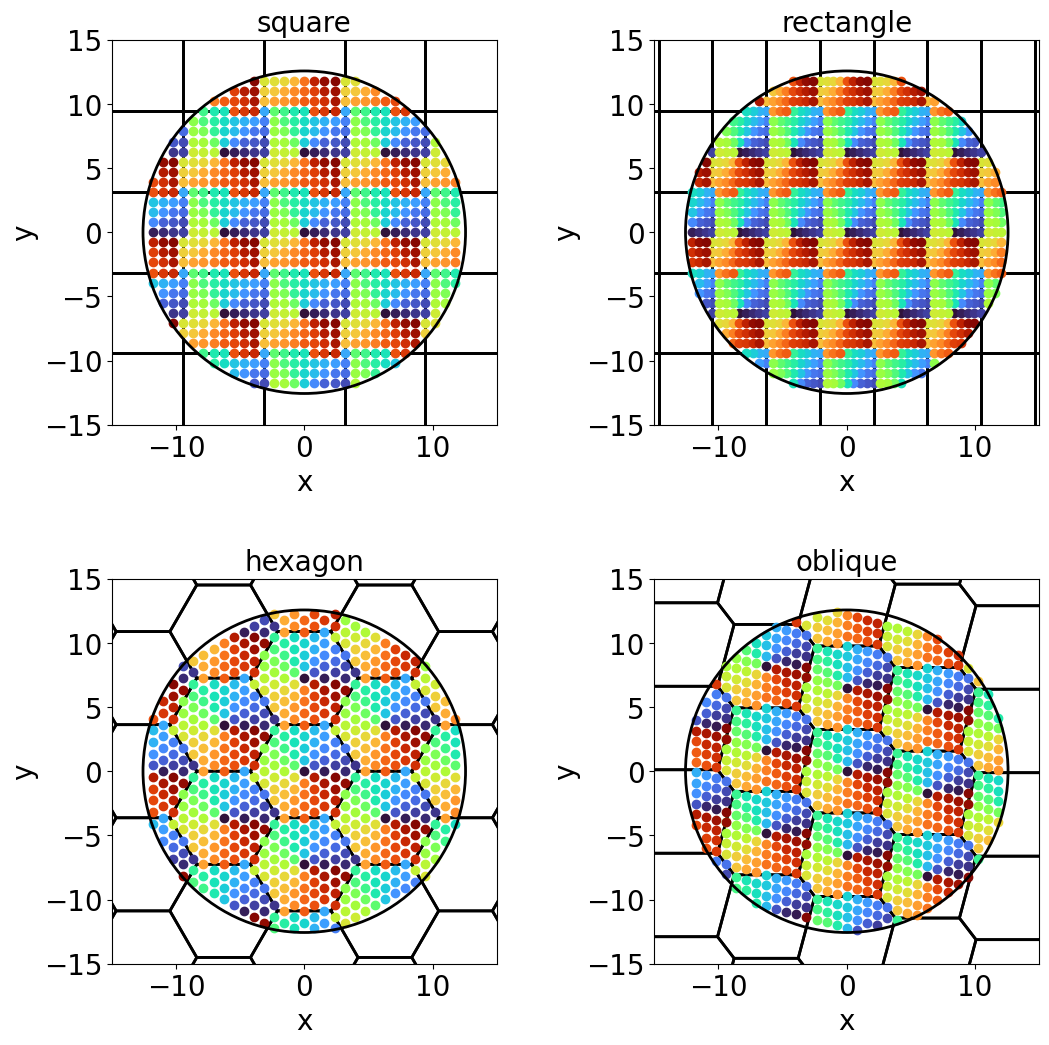

In [11]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    families = kspace.periodic_sampler.sample_bloch_families()
    canvas.plot_bloch_families(families)
      
    
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

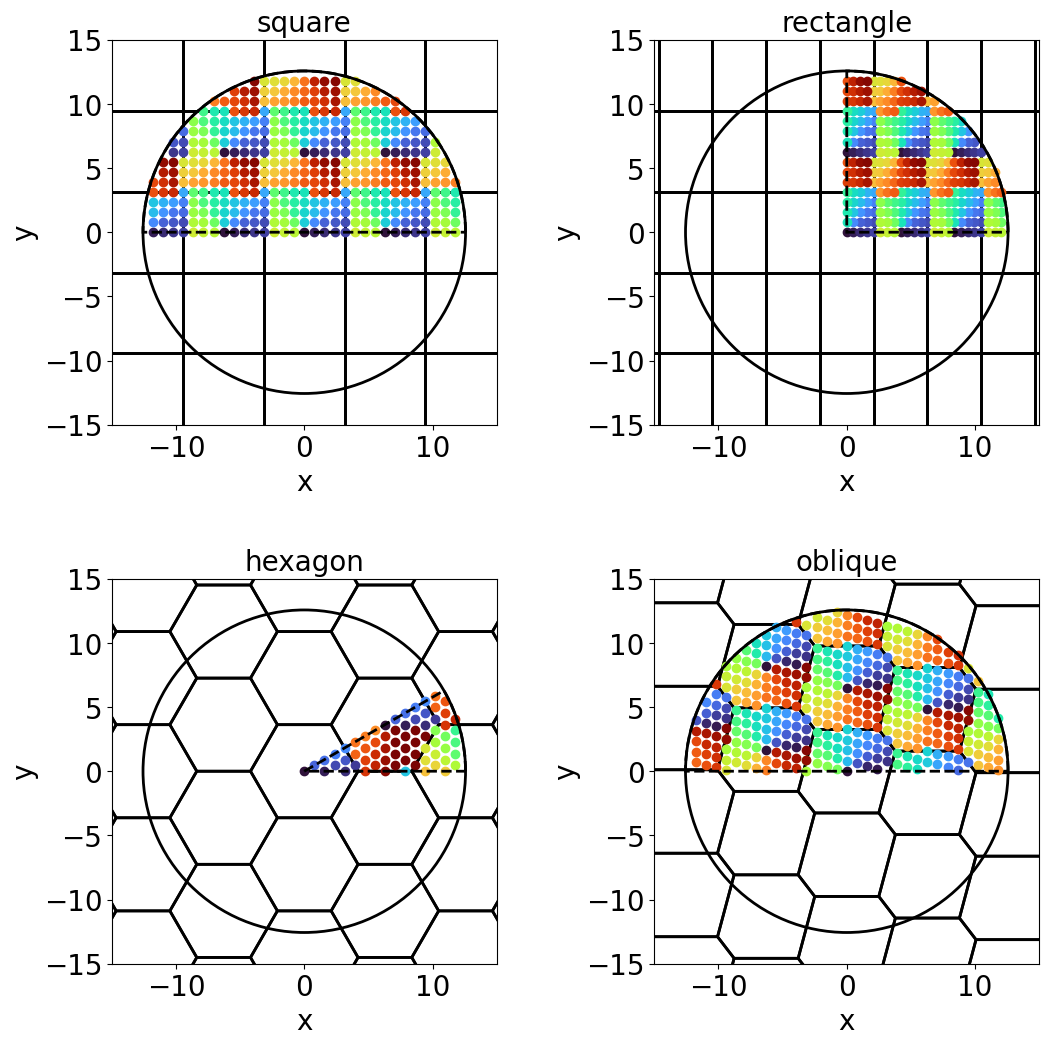

In [12]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    families = kspace.periodic_sampler.sample_bloch_families(restrict_to_sym_cone=True)
    canvas.plot_bloch_families(families)
    canvas.plot_symmetry_cone(kspace)
    
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

IndexError: list index out of range

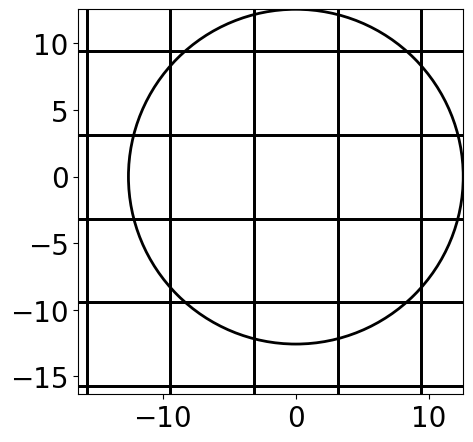

In [13]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)
    canvas.plot_fermi_circle(kspace)
    sampling = kspace.periodic_sampler.sample(restrict_to_sym_cone=True, constraint={'type':'n_points', 'value':4})
    #canvas.plot_sampling(sampling.k,  color='k')
    groups = kspace.symmetrise_sample(sampling)
    canvas.plot_symmetry_cone(kspace)    
    
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(groups)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)
        canvas.plot_point_sampling(groups[i], plot_n_points='all', color = color)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

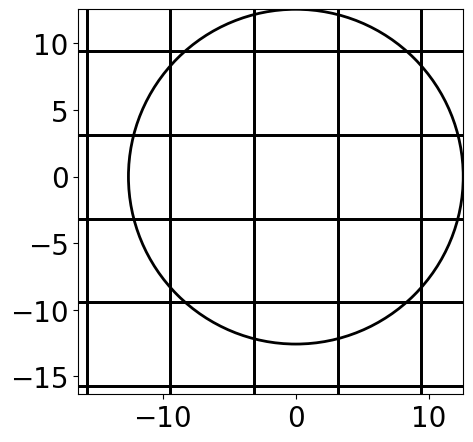

In [14]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(1, n_refinements = 4)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)

    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(2, n_refinements = 4)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)

    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(1, n_refinements = 4, restrict_to_sym_cone=True)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)
    canvas.plot_symmetry_cone(kspace)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(1, n_refinements = 4, restrict_to_sym_cone=True)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        #canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)
        sym_woods = kspace.symmetrise_sample(woods1[i])
        for i_wood in range(len(sym_woods)):
            canvas.plot_point_sampling(sym_woods[i_wood], color=color)
        
    canvas.plot_symmetry_cone(kspace)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)